In [83]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import shap
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.pipeline import Pipeline



sns.set(style="whitegrid")


In [3]:
df = pd.read_csv("data/Telco-Customer-Churn.csv")

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### EDA

In [8]:
df.shape

(7043, 21)

In [9]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [16]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [13]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [14]:
df.describe(include='object')   

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,3186-AJIEK,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,20.2,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


## Visual EDA

#### Churn vs Categorical Features

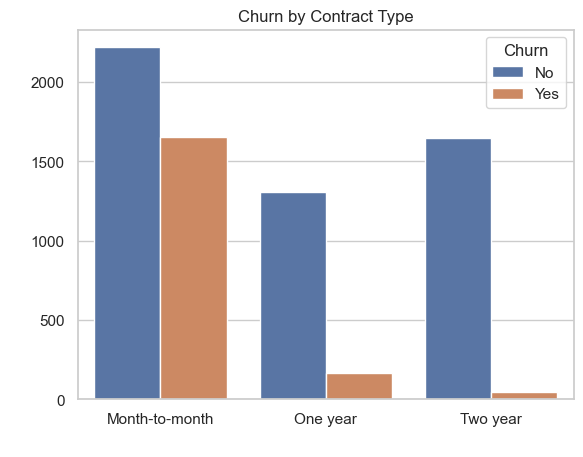

In [ ]:
# Contract Type vs Churn
sns.countplot(x='Contract', hue='Churn', data = df)
plt.title('Churn by Contract Type')
plt.xticks()
plt.xlabel(" ")
plt.ylabel(" ")
plt.show()

- months contract seems to chrun more

- long term contracts safer more

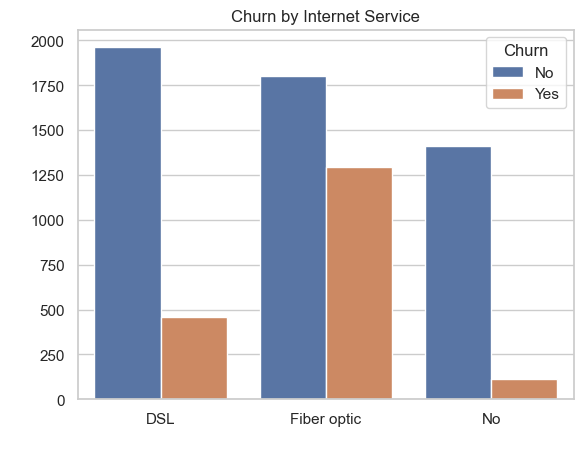

In [22]:
# Internet Service vs Churn
sns.countplot(x='InternetService', hue='Churn', data = df)
plt.title('Churn by Internet Service')
plt.xticks()
plt.xlabel(" ")
plt.ylabel(" ") 
plt.show()

- Fiber optic seems to  churn more

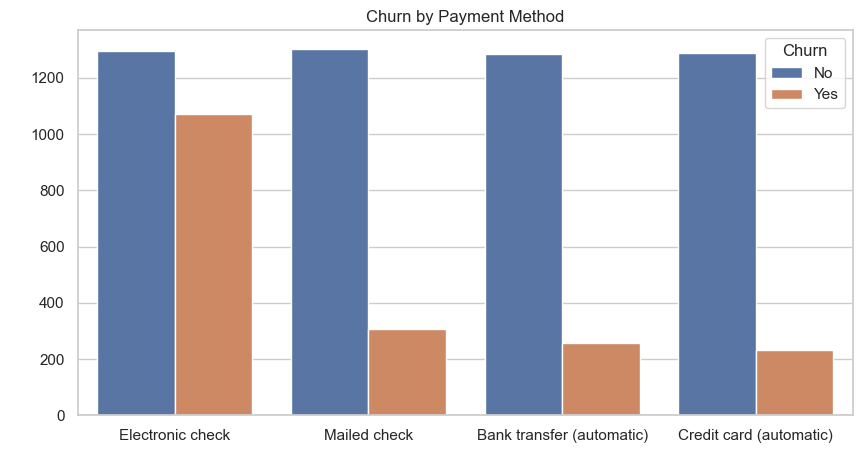

In [23]:
# PaymentMethod vs Churn
plt.figure(figsize=(10,5))
sns.countplot(x='PaymentMethod', hue='Churn', data = df)
plt.title('Churn by Payment Method')    
plt.xticks()
plt.xlabel(" ")     
plt.ylabel(" ")
plt.show()

- electronic check is more likely to churn

### Churn vs Numerical Features

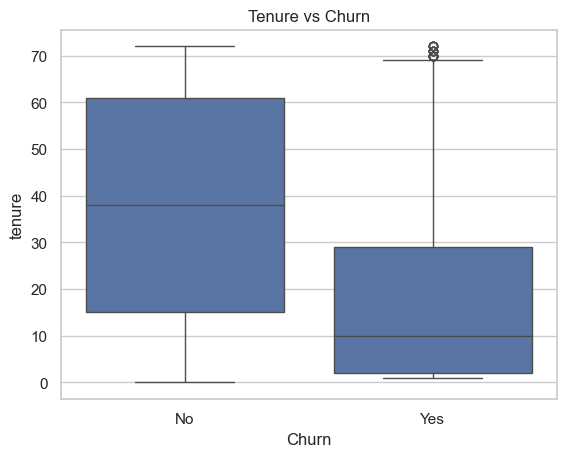

In [25]:
# tenure vs Churn (How long have they been with the company)
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Tenure vs Churn')
plt.show()

- customers with low tenure likely to be churn

C:\Users\erand\AppData\Local\Temp\ipykernel_23192\1582894295.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Churn'] == 'Yes']['MonthlyCharges'], label='Churned', shade = True)
C:\Users\erand\AppData\Local\Temp\ipykernel_23192\1582894295.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Churn'] == 'No']['MonthlyCharges'], label='Retained', shade = True)


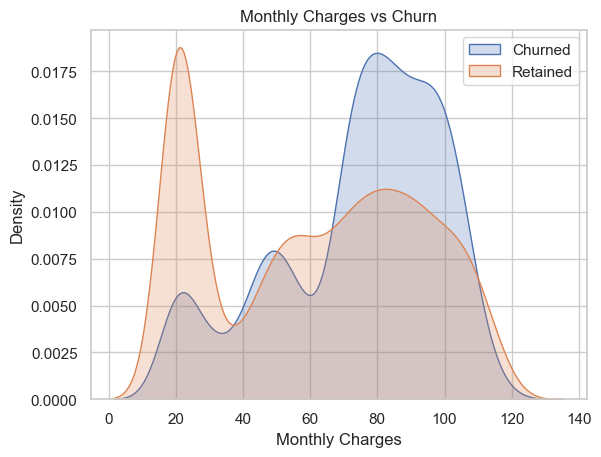

In [26]:
# MonthlyCharges vs Churn (How much they pay monthly)
sns.kdeplot(df[df['Churn'] == 'Yes']['MonthlyCharges'], label='Churned', shade = True)
sns.kdeplot(df[df['Churn'] == 'No']['MonthlyCharges'], label='Retained', shade = True)
plt.title('Monthly Charges vs Churn')
plt.legend()
plt.xlabel("Monthly Charges")       
plt.ylabel("Density")
plt.show()

- churned users are paying more monthly

### Correlation

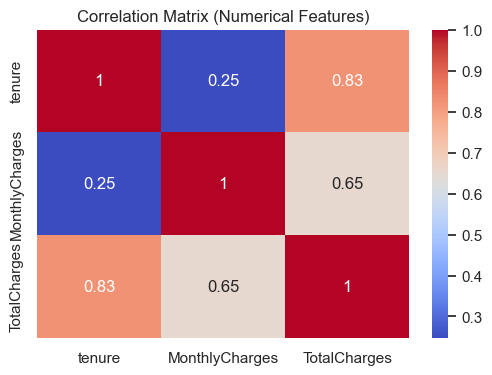

In [28]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(6,4))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numerical Features)')
plt.show()

### Cross Feature Insight

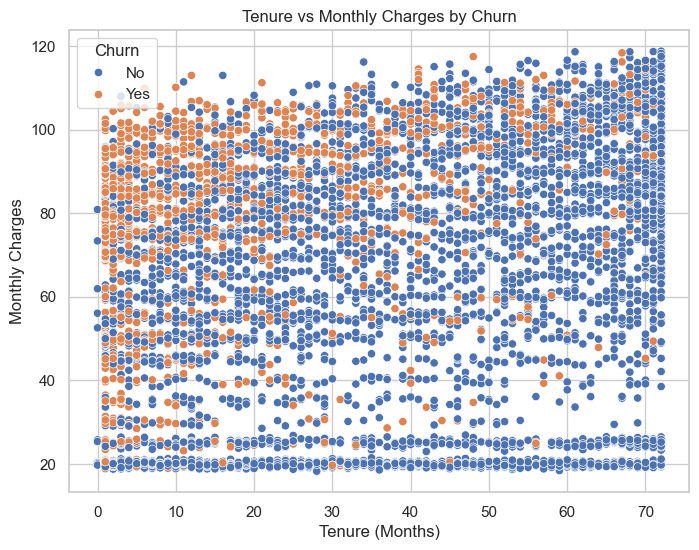

In [29]:
# is short-tenure + high monthly charges a problem?
plt.figure(figsize=(8,6))
sns.scatterplot(data = df, x = 'tenure', y = 'MonthlyCharges', hue = 'Churn')
plt.title('Tenure vs Monthly Charges by Churn')
plt.xlabel("Tenure (Months)")
plt.ylabel("Monthly Charges")

plt.show()

- it look like short term high charge area more likely to be churn

## Feature Engineering

In [30]:
# handling missing values in TotalCharges column
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(df['TotalCharges'].isnull().sum())    

11


- we can observe 11 missing values

In [33]:
df['TotalCharges'].fillna(0, inplace=True)

C:\Users\erand\AppData\Local\Temp\ipykernel_23192\171940771.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


In [34]:
# drop unnecessary columns
df.drop(columns=['customerID'],axis= 1, inplace=True)

In [35]:
# encode target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [37]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


#### Handle Categorical Variables

In [39]:
# split columns into types
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols.remove('Churn')

In [40]:
# one hot encoding for categorical variables
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [41]:
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False


In [43]:
# Feature scaling
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.439916,-1.277445,-1.160323,-0.992611,0,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False
1,-0.439916,0.066327,-0.259629,-0.172165,0,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True
2,-0.439916,-1.236724,-0.362660,-0.958066,1,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True
3,-0.439916,0.514251,-0.746535,-0.193672,0,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False
4,-0.439916,-1.236724,0.197365,-0.938874,1,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False


In [44]:
# Create New Feature
df['AvgChargePerMonth'] = df['TotalCharges'] / (df['tenure'] + 1)  # Avoid div by 0

### Model Selection

In [ ]:
# Create Baseline Model
## We have inbalanced classes, so we will use stratified sampling
x = df.drop(columns=['Churn'], axis=1)
y = df['Churn']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")

Train shape: (5634, 31), Test shape: (1409, 31)


In [46]:
# Train base line model
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

In [51]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)    
y_pred_rf = rf.predict(x_test)

In [53]:
# Evaluate Models
def evaluate_model(y_true, y_pred, model_name):
    print(f"------{model_name}------")
    print("confusion_matrix")
    print(confusion_matrix(y_true, y_pred)) 
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

In [54]:
# call the evaluate  models
evaluate_model(y_test,y_pred_lr, "Logistic Regression")
evaluate_model(y_test,y_pred_rf, "Random Forest Classifier")

------Logistic Regression------
confusion_matrix
[[925 110]
 [164 210]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

------Random Forest Classifier------
confusion_matrix
[[928 107]
 [181 193]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.64      0.52      0.57       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



In [56]:
print("Logistic AUC:", roc_auc_score(y_test, lr.predict_proba(x_test)[:,1]))
print("Random Forest AUC:", roc_auc_score(y_test, rf.predict_proba(x_test)[:,1]))

Logistic AUC: 0.8432741739647112
Random Forest AUC: 0.8257059081867266


-  Logistic Regression slightly outperformed Random Forest for churn class (positive class = 1)
-   But both models struggle with recall—failing to catch many customers who churned

### smart Model Improvements

In [58]:
# Try class weights
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

In [59]:
rf = RandomForestClassifier(n_estimators=100, class_weight = 'balanced', random_state=42)
rf.fit(x_train, y_train)    
y_pred_rf = rf.predict(x_test)

In [60]:
evaluate_model(y_test,y_pred_lr, "Logistic Regression")
evaluate_model(y_test,y_pred_rf, "Random Forest Classifier")

------Logistic Regression------
confusion_matrix
[[750 285]
 [ 79 295]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409

------Random Forest Classifier------
confusion_matrix
[[936  99]
 [189 185]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.65      0.49      0.56       374

    accuracy                           0.80      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.80      0.79      1409



In [61]:
print("Logistic AUC:", roc_auc_score(y_test, lr.predict_proba(x_test)[:,1]))
print("Random Forest AUC:", roc_auc_score(y_test, rf.predict_proba(x_test)[:,1]))

Logistic AUC: 0.8429125009687669
Random Forest AUC: 0.8252305665349143


In [64]:
# Tune Random Forest Classifier (GridSearchCV)

params = {
    'n_estimators': [100, 200],
    'max_depth':[5,10, None],
    'min_samples_split':[2, 5, 10],
}

grid_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced'), params, scoring = 'f1', cv= 3, verbose=1)
grid_rf.fit(x_train, y_train)

best_rf  = grid_rf.best_estimator_
y_pred_best = best_rf.predict(x_test)
evaluate_model(y_test,y_pred_best, "Tuned Random Forest Classifier")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
------Tuned Random Forest Classifier------
confusion_matrix
[[801 234]
 [ 99 275]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1035
           1       0.54      0.74      0.62       374

    accuracy                           0.76      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.76      0.77      1409



In [68]:
xgb = XGBClassifier(scale_pos_weight=3, use_label_encoder=False, eval_metric='logloss')
xgb.fit(x_train, y_train)
y_pred_xgb = xgb.predict(x_test)
evaluate_model(y_test, y_pred_xgb, "XGBoost")

------XGBoost------
confusion_matrix
[[807 228]
 [107 267]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1035
           1       0.54      0.71      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409



c:\Users\erand\anaconda3\envs\study\lib\site-packages\xgboost\training.py:183: UserWarning: [22:40:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Feature Importance and Interpretation

- Why are people churning?

- Which features are driving the model's decisions?

In [70]:
# Random forest feature importance
importances = best_rf.feature_importances_
features = x.columns
feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df.sort_values(by='Importance', ascending=False).head(10)


,Feature,Importance
1,tenure,0.157814
30,AvgChargePerMonth,0.113591
3,TotalCharges,0.108303
25,Contract_Two year,0.097416
2,MonthlyCharges,0.086712
10,InternetService_Fiber optic,0.071154
28,PaymentMethod_Electronic check,0.054439
24,Contract_One year,0.034999
13,OnlineSecurity_Yes,0.025729
19,TechSupport_Yes,0.022180


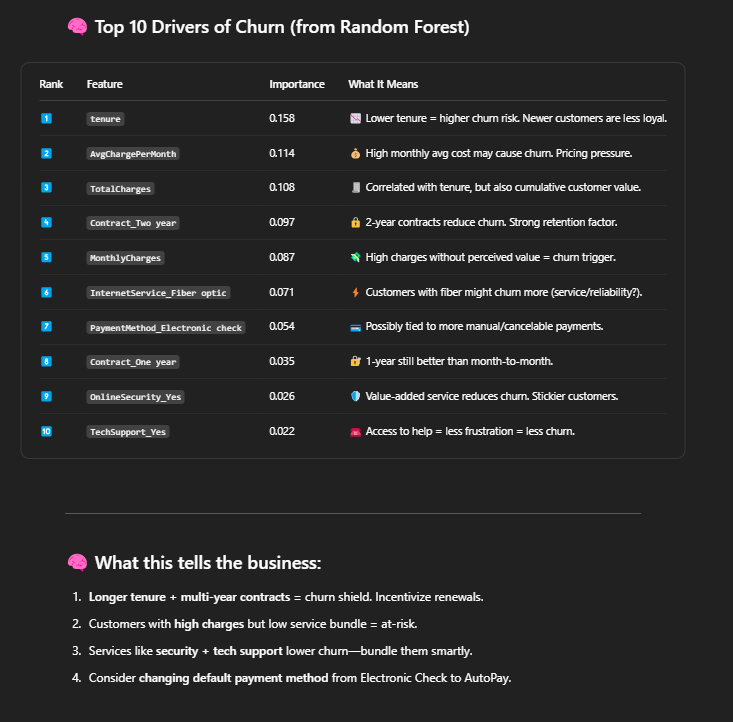

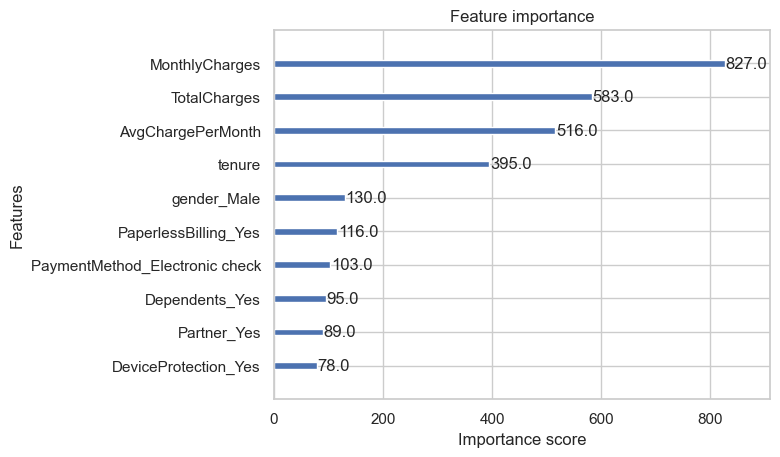

In [72]:
# XGBoost Plot
plot_importance(xgb, max_num_features=10)
plt.show()

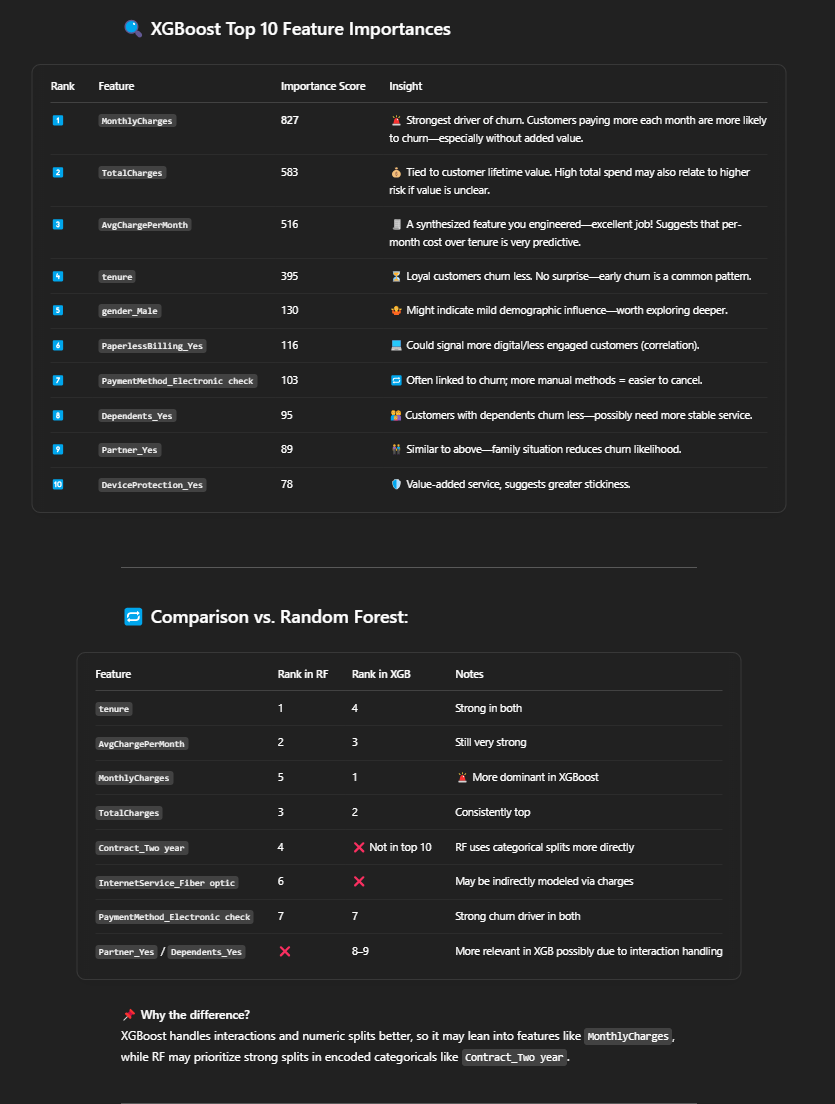

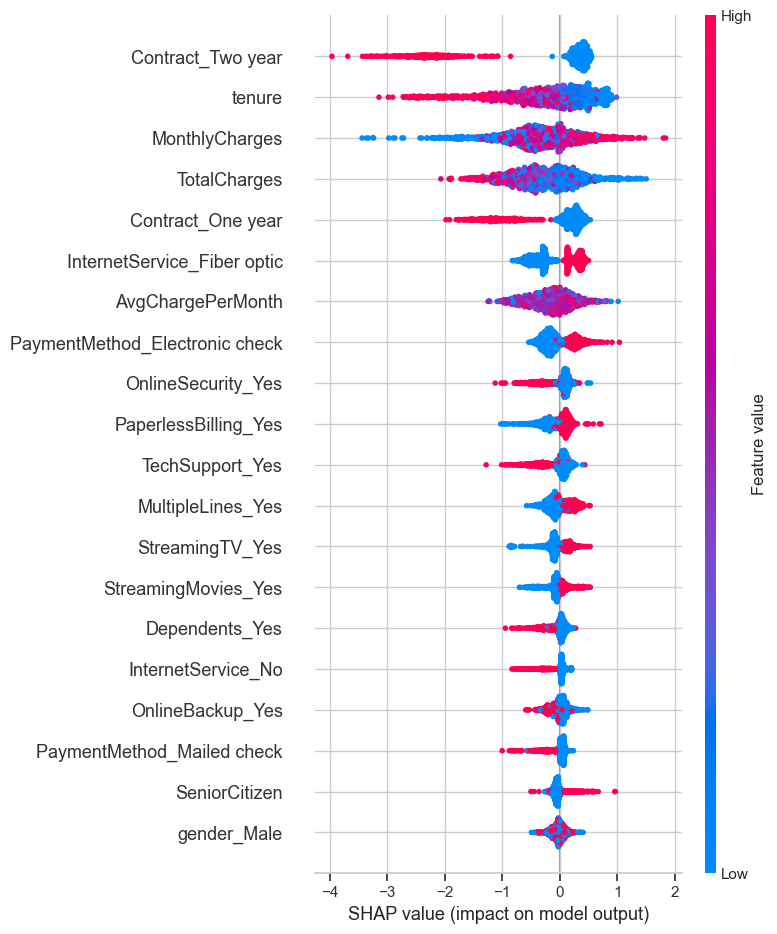

In [76]:
# SHAP for Interpretability
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x_test)

# Summary plot
shap.summary_plot(shap_values, x_test)

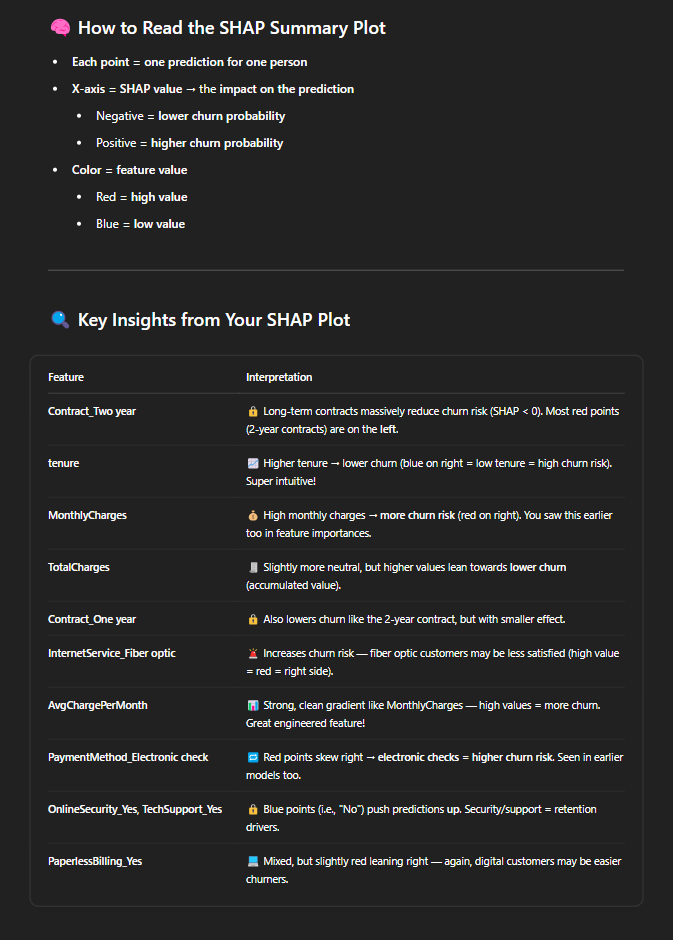

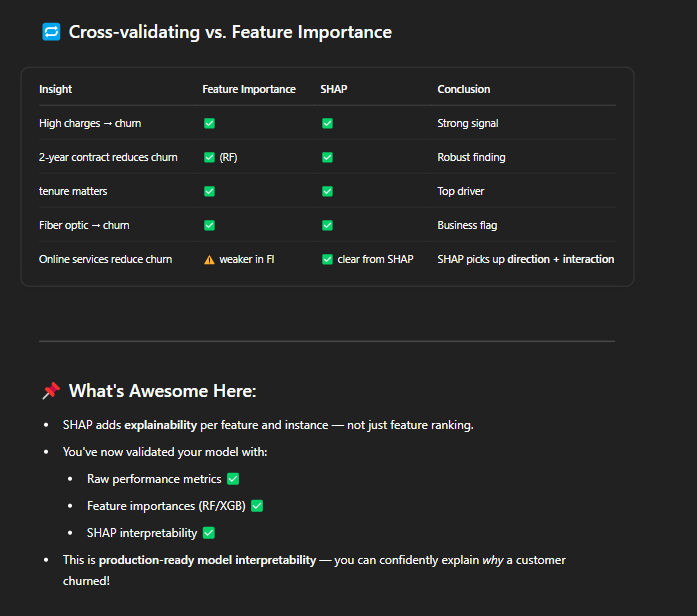

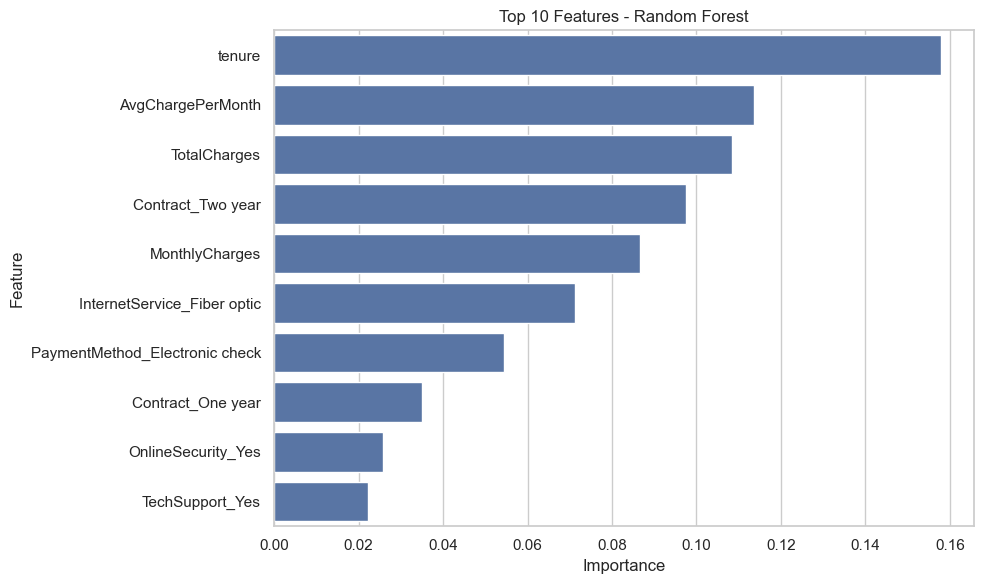

                           Feature  Importance
1                           tenure    0.157814
30               AvgChargePerMonth    0.113591
3                     TotalCharges    0.108303
25               Contract_Two year    0.097416
2                   MonthlyCharges    0.086712
10     InternetService_Fiber optic    0.071154
28  PaymentMethod_Electronic check    0.054439
24               Contract_One year    0.034999
13              OnlineSecurity_Yes    0.025729
19                 TechSupport_Yes    0.022180


In [78]:

# Get feature importances from the tuned Random Forest model
rf_feat = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 10
plt.figure(figsize=(10,6))
sns.barplot(data=rf_feat.head(10), x='Importance', y='Feature')
plt.title("Top 10 Features - Random Forest")
plt.tight_layout()
plt.show()

# Also print top 10 features for reference
print(rf_feat.head(10))

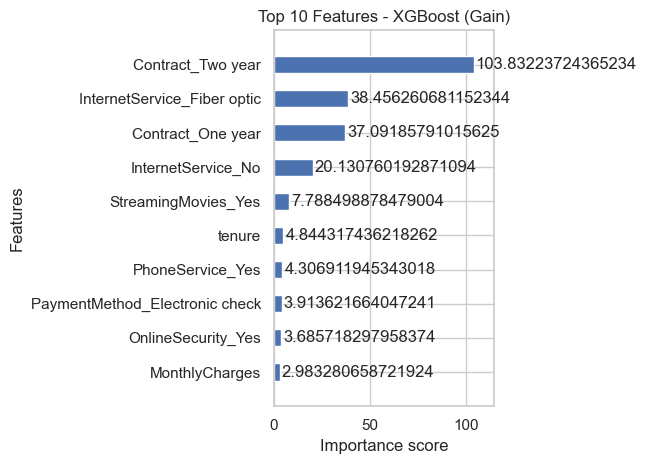

In [79]:
from xgboost import plot_importance

# Plot top 10 features by gain (amount they improve decision trees)
plot_importance(xgb, max_num_features=10, height=0.5, importance_type='gain')
plt.title("Top 10 Features - XGBoost (Gain)")
plt.tight_layout()
plt.show()

In [87]:
joblib.dump(xgb, 'xgb_model.pkl')

['xgb_model.pkl']